# Vaximap EDA

##  Table of Contents

* [Initialisation](#Initialisation)
* [Load Dataset](#Load-Dataset)
* [Duplicate Analysis](#Duplicate-Analysis)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
* [Assessing Patient Clustering](#Assessing-Patient-Clustering)
* [Appendix](#Appendix)

## Initialisation

In [301]:
'------------Import Modules------------'
import warnings
warnings.filterwarnings('ignore')

# DS Modules
import random
import datetime
import pandas as pd
import numpy as np
import itertools

# Visualisation
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import seaborn as sns

# Statistical Tests
from scipy.stats import (normaltest, ttest_ind, chi2_contingency,
                         chi2, cumfreq, norm, kstest, shapiro,
                        percentileofscore)
import statsmodels.api as sm

# Clustering
import hdbscan
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import haversine_distances
from scipy.cluster.hierarchy import dendrogram

# Import dataset
from load_dataset import dataset

# Import functions used in this notebook
from vaximapFunctions import *

# Import geolocation modules
import geopandas
from shapely.geometry import Polygon, Point, LineString

# tqdm
from tqdm import tqdm

In [2]:
# Set up notebook parameters
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
output_notebook() # outputs bokeh plots directly in notebook

Loading BokehJS ...

In [3]:
# Set configuration parameters
random_seed = 42
random.seed = random_seed
centre_lon_lat = (-1.2, 53) # defined as approximate centre of UK

# set constants in dataset
avg_road_speed = 30 #mph
detour_index = 1.4
distance_threshold = 15000 * 1.6

## Load Dataset

In [4]:
# Plot example row of df
print("Length of raw dataset = {:,}".format(len(dataset)))
print("Number of patients in raw dataset = {:,}".format(dataset.n_patients.sum()))
dataset.head(1)

Length of raw dataset = 8,659
Number of patients in raw dataset = 286,924


,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode
0,6,1,"[[-0.0011351833333321792, -0.03472788333333332], [0.0018483166666669604, -0.03430198333333312], [0.0005629166666665242, 0.018650416666667002], [-0.0023297833333302265, 0.018505116666666765], [0.002702216666669699, 0.015526416666666876], [-0.0016484833333336724, 0.016347916666666684]]","[[2, 3, 5, 4, 1, 0]]",UK,{},2021-01-23,driving


## Duplicate Analysis

N.B: For now assuming duplicate lat/lon within nested list in one row is because these patients share the same address, rather than clerical error e.g. if user accidentally has duplicates patients in their excel sheet.


In [5]:
# Test to identify duplicates: need to convert latlong numpy to string beforehand to be able to drop
df1 = dataset.copy()[["latlong"]]
df1.latlong = df1.latlong.astype("str")
df1 = df1.sort_values("latlong")

# extract number of duplicates from pandas duplicated inbuilt function
df1["is_duplicate"] = df1.duplicated(subset="latlong", keep="last")
print("Number of duplicates = {:,}".format(len(df1.loc[df1.is_duplicate == True])))

Number of duplicates = 2,849


In [6]:
# Demonstrate example of duplicate indices:
df1["is_duplicate_keep_both"] = df1.duplicated(subset="latlong", keep=False)
df1.loc[df1.is_duplicate_keep_both == True][15:18].reset_index()

,index,latlong,is_duplicate,is_duplicate_keep_both
0,175,[[ 0.00013685 0.0024527 ]\n [-0.00220345 0.0007388 ]\n [ 0.00138085 -0.0007581 ]\n [ 0.00069865 -0.0018543 ]\n [ 0.00069865 -0.0018543 ]\n [ 0.00298735 -0.0024562 ]\n [-0.00184945 0.0018657 ]\n [-0.00184945 0.0018657 ]],True,True
1,176,[[ 0.00013685 0.0024527 ]\n [-0.00220345 0.0007388 ]\n [ 0.00138085 -0.0007581 ]\n [ 0.00069865 -0.0018543 ]\n [ 0.00069865 -0.0018543 ]\n [ 0.00298735 -0.0024562 ]\n [-0.00184945 0.0018657 ]\n [-0.00184945 0.0018657 ]],True,True
2,173,[[ 0.00013685 0.0024527 ]\n [-0.00220345 0.0007388 ]\n [ 0.00138085 -0.0007581 ]\n [ 0.00069865 -0.0018543 ]\n [ 0.00069865 -0.0018543 ]\n [ 0.00298735 -0.0024562 ]\n [-0.00184945 0.0018657 ]\n [-0.00184945 0.0018657 ]],False,True


In [7]:
# Show indices of most occurring entry:

df1.loc[df1.latlong == df1.groupby("latlong").count().sort_values("is_duplicate", ascending=False).index.values[0]].sort_index().index.values

array([   1,  311,  403,  547, 1012, 1014, 1016, 1188, 1201, 1250, 1315,
       1476, 1516, 1687, 1901, 1926, 1931, 1972, 1974, 1975, 1977, 1991,
       1994, 2048, 2049, 2051, 2131, 2154, 2155, 2203, 2258, 2970, 2971,
       2977, 2995, 2996, 4391], dtype=int64)

In [11]:
print("Number of distinct sets in dataset = {}".format(len(df1.loc[df1.is_duplicate == False])))

Number of distinct sets in dataset = 5810


(array([1.237e+03, 1.980e+02, 5.700e+01, 1.400e+01, 1.200e+01, 4.000e+00,
        3.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([ 2.  ,  3.75,  5.5 ,  7.25,  9.  , 10.75, 12.5 , 14.25, 16.  ,
        17.75, 19.5 , 21.25, 23.  , 24.75, 26.5 , 28.25, 30.  , 31.75,
        33.5 , 35.25, 37.  ]),
 <BarContainer object of 20 artists>)

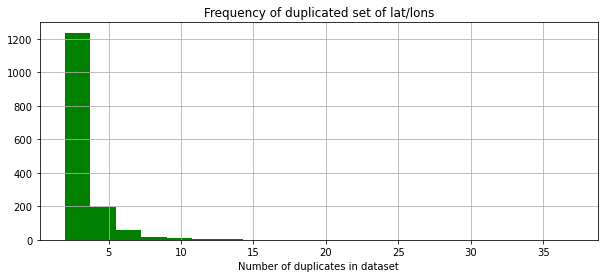

In [21]:
# plot histogram of frequency of duplicate set occurring (not showing cases without duplicates)
x = df1.groupby("latlong").count().sort_values("is_duplicate", ascending=False)
x = x.loc[x.is_duplicate > 1]

plt.figure(figsize=(10,4))
plt.grid()
plt.title("Frequency of duplicated set of lat/lons")
plt.xlabel("Number of duplicates in dataset")
plt.hist(x.is_duplicate, bins=20, color="green")

In [12]:
# create record_id and join to dataset
idf = df1.sort_values("latlong")
idn = 1
id_list = [1]

for i in range(1, len(idf)):
    if idf.latlong.values[i] == idf.latlong.values[i - 1]:
        id_list.append(idn)
    else:
        idn += 1
        id_list.append(idn)
        
idf["record_id"] = id_list

# join
dataset = dataset.join(idf[["record_id"]])

In [13]:
# Check duration between duplicates
dataset["created"] = pd.to_datetime(dataset["created"])

dup = df1.loc[df1.is_duplicate_keep_both == True]
dup = dup.join(idf[["record_id"]])

time_bet = pd.DataFrame()

for latlong in dup.latlong.unique()[:]:
    dup1 = dup.loc[dup.latlong == latlong]
    index_list = dup1.index.values
    dat = dataset.iloc[index_list].sort_values("created")
    dat["time_between"] = (dat["created"] - dat["created"].shift(1)).dt.days
    time_bet = time_bet.append(dat[1:])


(array([2.784e+03, 2.500e+01, 1.000e+01, 5.000e+00, 5.000e+00, 2.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 3.000e+00]),
 array([ 0.  ,  1.25,  2.5 ,  3.75,  5.  ,  6.25,  7.5 ,  8.75, 10.  ,
        11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  , 21.25,
        22.5 , 23.75, 25.  ]),
 <BarContainer object of 20 artists>)

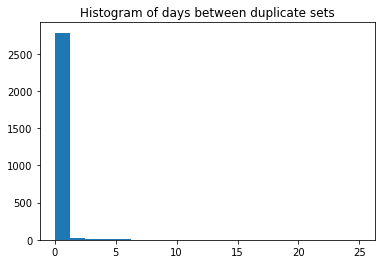

In [16]:
# plot histogram of time between duplicate sets
plt.title("Histogram of days between duplicate sets")
plt.hist(time_bet.time_between, bins=20)

Can see here that vast majority of duplicates occur same day, only a minority occurring on further days

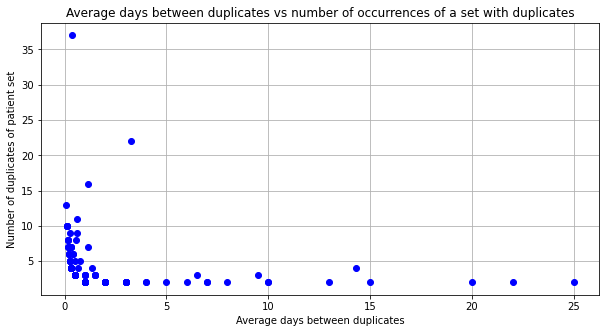

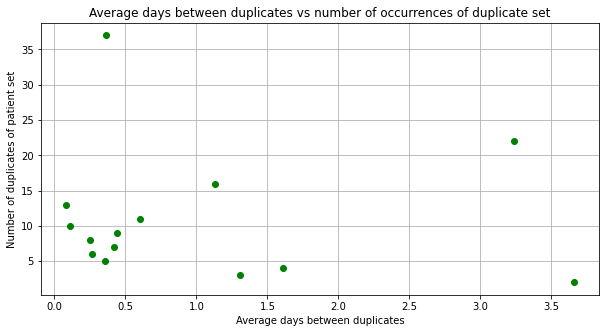

In [18]:
# plot scatters comparing days between duplicates vs number of duplicates 

# dataframe to get average duration per duplicate per set
record_time_bet = time_bet.groupby("record_id").mean()
record_time_bet = record_time_bet.join(dup.groupby("record_id").count()[["latlong"]].rename(columns={"latlong" : "occurrences"}))

# filter for those where mean time > 0
record_time_bet1 = record_time_bet.loc[record_time_bet.time_between > 0]

plt.figure(figsize=(10,5))
plt.grid()
plt.title("Average days between duplicates vs number of occurrences of a set with duplicates")
plt.xlabel("Average days between duplicates")
plt.ylabel("Number of duplicates of patient set")
plt.plot( record_time_bet1.time_between, record_time_bet1.occurrences, "bo")

record_time_bet2 = record_time_bet1.groupby("occurrences").mean().reset_index()
plt.figure(figsize=(10,5))
plt.grid(which="both")
plt.title("Average days between duplicates vs number of occurrences of duplicate set")
plt.xlabel("Average days between duplicates")
plt.ylabel("Number of duplicates of patient set")
plt.plot( record_time_bet2.time_between, record_time_bet2.occurrences, "go")
plt.show()

In [19]:
# records with large occurrences
record_time_bet.loc[record_time_bet.occurrences > 15]

,n_patients,n_clusters,time_between,occurrences
record_id,,,,
93,8.0,1.000000,0.000000,18
1781,24.0,3.952381,3.238095,22
1831,24.0,2.805556,0.361111,37
3081,6.0,1.133333,1.133333,16


In [20]:
# records with long timespan
record_time_bet.loc[record_time_bet.time_between > 10]

,n_patients,n_clusters,time_between,occurrences
record_id,,,,
306,8.0,1.0,15.000000,2
1621,8.0,1.0,25.000000,2
1780,24.0,3.0,14.333333,4
2546,32.0,3.0,22.000000,2
2894,8.0,1.0,13.000000,2
3669,5.0,1.0,20.000000,2


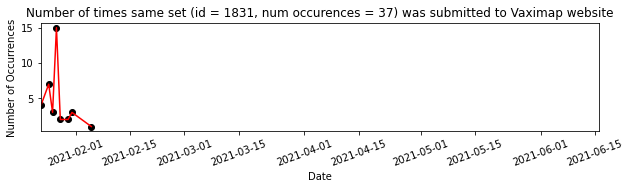

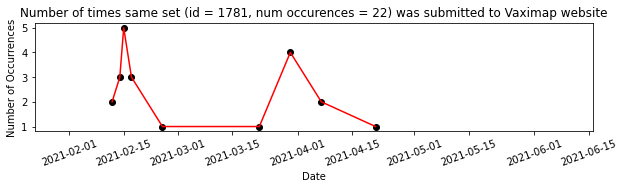

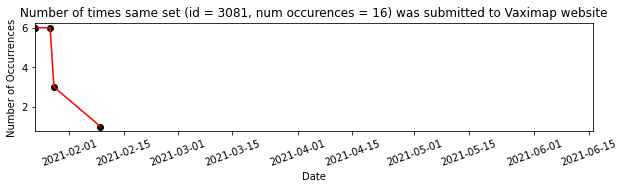

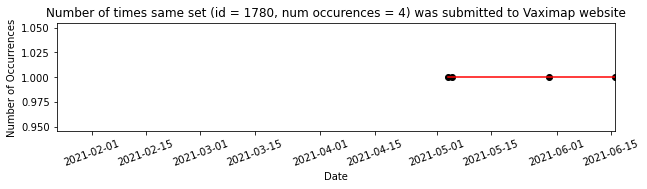

In [21]:
example_ids = [1831, 1781, 3081, 1780]
for record in example_ids:
    occurrences = record_time_bet.loc[record_time_bet.index == record].occurrences.values[0]
    example = dataset.loc[dataset.record_id == record][["record_id", "created"]]
    example = example.groupby("created").count().reset_index()

    plt.figure(figsize=(10,2))
    plt.title("Number of times same set (id = {a}, num occurences = {b}) was submitted to Vaximap website".format(a=record, b=occurrences))
    plt.xlabel("Date")
    plt.xticks(rotation=20)
    plt.ylabel("Number of Occurrences")
    plt.xlim(dataset.created.min(), dataset.created.max())
    plt.plot(example.created, example.record_id, "r")
    plt.scatter(example.created, example.record_id, color="black")
    plt.show()

It appears that the ID=1831 is Tom's test dataset.

## Exploratory Data Analysis

In [26]:
# we remove from dataset Tom's test set for EDA
df0 = dataset.loc[dataset.record_id != 1831]

# Create new feature: max cluster size
df0["max_cluster_size"] = df0["clusters"].apply(FindMaxLength)

# Create new feature: postcodes size (used to filter empty postcode dicts)
df0["postcodes_size"] = [len(i) for i in df0.postcodes]


In [27]:
# Remove duplicate indices from raw dataset, keeping "last" assuming earlier duplicates were for testing
df = df0.loc[df0.index.isin(df1.loc[df1.is_duplicate == False].index.values)]
print("Length of dataset without duplicates = {:,}".format(len(df)))
print("Number of patients in dataset without duplicates = {:,}".format(df.n_patients.sum()))

Length of dataset without duplicates = 5,809
Number of patients in dataset without duplicates = 179,049


In [28]:
# Plot usage per day: group by date to get df_usage
df_usage = df.groupby(df.created).count().reset_index()

p1 = figure(x_axis_type="datetime", title="Number of Vaximap requests per date", plot_width=800, plot_height=300)
p1.grid.grid_line_alpha = 0.3
p1.xaxis.axis_label = 'Date'
p1.yaxis.axis_label = 'Request Frequency'
p1.line(df_usage.created, df_usage.n_patients)
show(p1)

n_clusters: 
Number of distinct categories = 31 
Majority class = '1' with 2871 (49%) of samples.
Number of nulls in feature = 0 (0.0%)


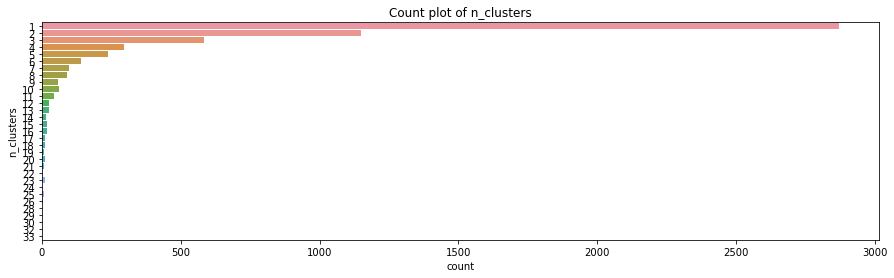

mode: 
Number of distinct categories = 2 
Majority class = 'driving' with 5761 (99%) of samples.
Number of nulls in feature = 0 (0.0%)


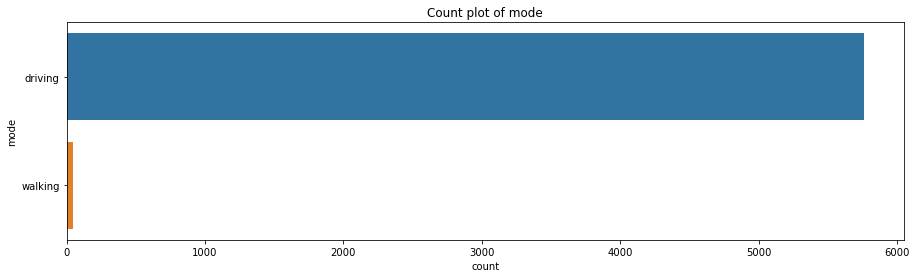

In [29]:
# Categorical variables
categorical_features = ['n_clusters', 'mode'] 
univariateCategorical(df, categorical_features)

(array([211., 286., 688., 852., 129., 189., 201., 114., 136.,  65.]),
 array([ 3. ,  5.2,  7.4,  9.6, 11.8, 14. , 16.2, 18.4, 20.6, 22.8, 25. ]),
 <BarContainer object of 10 artists>)

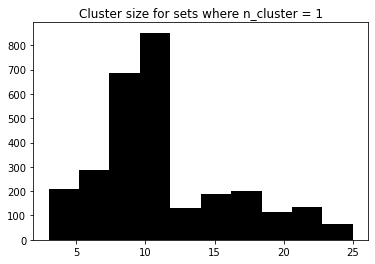

In [69]:
# Since many sets were just put into a single cluster, we check to see what max_cluster_size is picked
plt.title("Cluster size for sets where n_cluster = 1")
plt.hist(df.loc[df.n_clusters == 1]["max_cluster_size"], color="black")

,n_patients,n_clusters,max_cluster_size
count,5809.00,5809.00,5809.00
mean,31.00,3.00,12.00
std,41.00,3.00,5.00
min,3.00,1.00,3.00
25%,10.00,1.00,9.00
50%,18.00,2.00,11.00
75%,32.00,3.00,12.00
max,300.00,33.00,25.00
median,18.00,2.00,11.00
skew,3.59,3.56,1.09


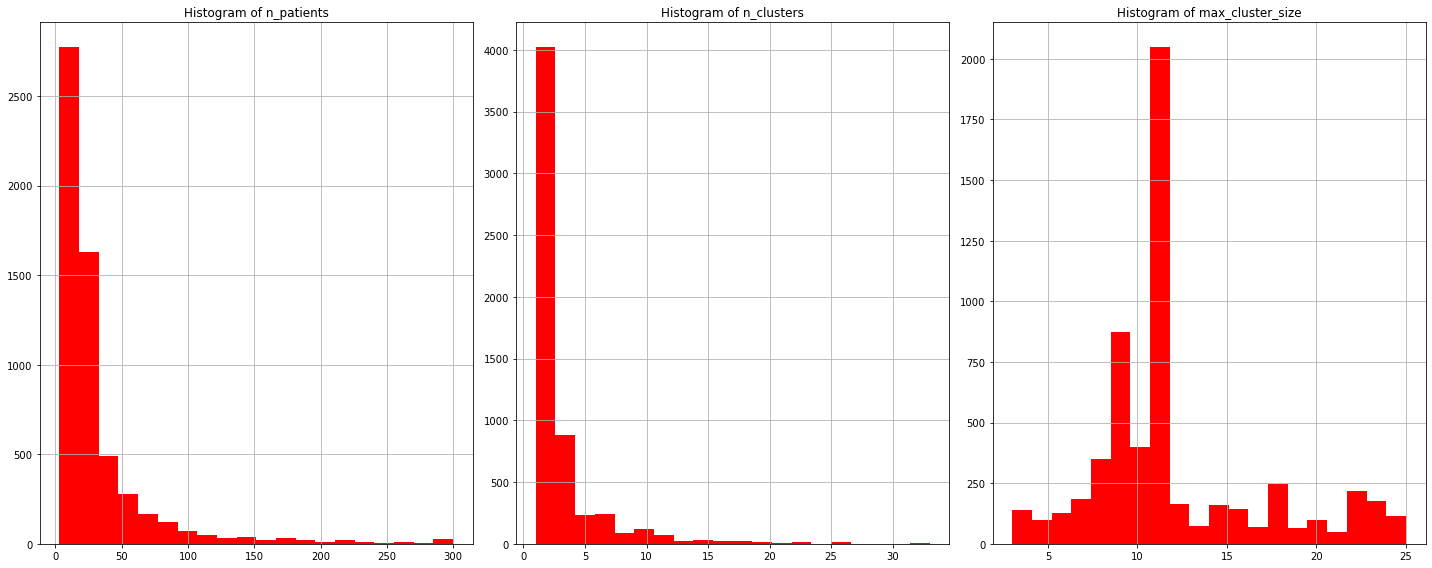

In [38]:
# Numerical variables
numerical_features = ['n_patients', 'n_clusters', 'max_cluster_size'] 
univariateContinuous(df, numerical_features)

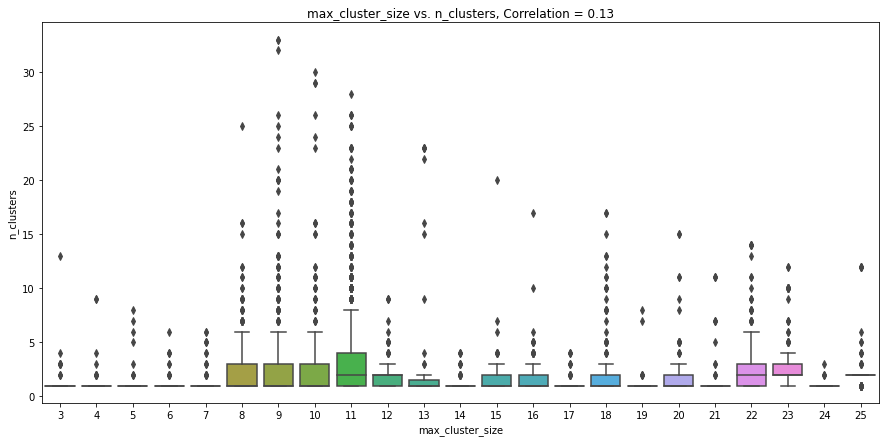

In [39]:
# Plot bivariate analysis between n_clusters and max_cluster_size
bivariateContinuous(df, "n_clusters", "max_cluster_size", corr_type="spearman")

### Observations:

* Mean n_patients = 31 and long tail, kurtosis = 15.45
* Most requests seemed to have used the website default value D = 11 for cluster size, secondary peak at D = 9 (explained by fact that AstraZeneca has 9 vials). 3 <= D <= 25 (which is what we need, probably due to form constraints set on vaximap website)

## Assessing Patient Clustering

Evaluating how well the iterative K means works. We compare clustering to non-optimised grouping to see how much time is saved in Delivery time (total time = Planning time + Delivery time, in this analysis not focusing on planning time).

Feedback from team:
* Max distance between points probably less than 20 miles so curvature does not kick in
* Check mean cluster diameter (differences in London vs remote)
* Duplicates due to either failed to save or visiting again
* GPs have no way of knowing who else is seeing their patients in the community

In [40]:
# explode dataset to only look at latlongs and clusters: locdf
latlongs_in_clusters = []
latlong_ids = []


for index, row in df0.iterrows():
    latlong = row["latlong"]
    clusters = row["clusters"]
    record_ids = row["record_id"]
    record_index = index
    
    for i in range(len(clusters)):
        cluster_no = str(i + 1)
        latlongs_in_cluster = []
        for j in clusters[i]:
            latlong_ids.append([latlong[j],
                                [sum(x) for x in list(zip(centre_lon_lat, latlong[j][::-1]))],
                                str(record_ids),
                                str(record_index) + "_" + cluster_no,
                                str(record_index) + "_" + cluster_no + "_" + str(clusters[i].index(j)),
                                j, record_index])
            latlongs_in_cluster.append(latlong[j])
        latlongs_in_clusters.append([latlongs_in_cluster, index, str(index) + "_" + cluster_no])

# split by individial latlong
locdf = pd.DataFrame(data={"latlong" : [x[0] for x in latlong_ids],
                    "geometry" : [Point(x[1]) for x in latlong_ids],
                   "record_id" : [x[2] for x in latlong_ids],
                   "cluster_no" : [x[3] for x in latlong_ids],
                   "id" : [x[4] for x in latlong_ids],
                    "patient_index" : [x[5] for x in latlong_ids],
                          "record_index" : [x[6] for x in latlong_ids]})

# # split by clusters - not necessary
# locdf2 = pd.DataFrame(data={"latlongs" : [x[0] for x in latlongs_in_clusters],
#                    "submission" : [x[2] for x in latlongs_in_clusters],
#                    "cluster_no" : [x[3] for x in latlongs_in_clusters],
#                    "geometry" : [Point(x[1][0]) if len(x[0]) == 1  \
#                                  else LineString(x[1]) if len(x[0]) == 2 \
#                                  else Polygon(x[1]) for x in latlongs_in_clusters],
#                    "cluster_length" : [len(x[0]) for x in latlongs_in_clusters]
#                    })

# convert to geopandas dataframe
locdf = geopandas.GeoDataFrame(locdf).set_crs("EPSG:4326")
# locdf2 = geopandas.GeoDataFrame(locdf2).set_crs("EPSG:4326")


In [41]:
# print example of locdf
locdf.head(1)

,latlong,geometry,record_id,cluster_no,id,patient_index,record_index
0,"[0.0005629166666665242, 0.018650416666667002]",POINT (-1.18135 53.00056),3081,0_1,0_1_0,2,0


In [42]:
# calculate distances:

# convert from longlat to metres
locdf1 = locdf.to_crs("EPSG:3857").sort_values("id") 

# calculate distance of adjacent rows
locdf1["distances"] = locdf1.geometry.distance(locdf1.geometry.shift(1)) 

# remove distances where succeeding row is part of a new cluster
locdf1["distances"] = np.where((locdf1.cluster_no == locdf1.cluster_no.shift(1)), locdf1["distances"], np.nan)

Data cleansing required next as some longlat relative coordinates are far too displaced, causing unrealistic distances

In [46]:
# example with large distance
locdf1.loc[locdf1.record_id == "3"].sort_values("distances", ascending=False)[:2]

,latlong,geometry,record_id,cluster_no,id,patient_index,record_index,distances
220133,"[2.086775628266601, -3.147616644754124]",POINT (-483974.471 7378725.739),3,6074_1,6074_1_9,4,6074,4.799910e+06
220102,"[2.086775628266601, -3.147616644754124]",POINT (-483974.471 7378725.739),3,6072_1,6072_1_9,4,6072,4.799910e+06


In [238]:
# example with large distance: raw dataset
dataset.loc[dataset.record_id == 3]

,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode,record_id
6072,10,1,"[[2.08087414887207, -3.1204763505982402], [2.0790434488720706, -3.10461375059824], [2.07788084887207, -3.1142305505982404], [2.073906448872073, -3.1185366505982404], [2.086775628266601, -3.147616644754124], [2.073569448872071, -3.12093015059824], [2.085673180756835, -3.1146086504599575], [2.0791432488720716, -3.11963465059824], [-18.71316575112793, 28.06691634940176], [2.0762993488720696, -3.10626895059824]]","[[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]",UK,{},2021-02-12,driving,3
6074,10,1,"[[2.08087414887207, -3.1204763505982402], [2.0790434488720706, -3.10461375059824], [2.07788084887207, -3.1142305505982404], [2.073906448872073, -3.1185366505982404], [2.086775628266601, -3.147616644754124], [2.073569448872071, -3.12093015059824], [2.085673180756835, -3.1146086504599575], [2.0791432488720716, -3.11963465059824], [-18.71316575112793, 28.06691634940176], [2.0762993488720696, -3.10626895059824]]","[[5, 3, 7, 0, 1, 9, 2, 6, 8, 4]]",UK,{},2021-02-12,driving,3


In [76]:
# filter out distance threshold

df.record_id = df.record_id.astype("str")
df0.record_id = df0.record_id.astype("str")


locdf2 = locdf1.loc[(locdf1.distances <= distance_threshold) | (locdf1.distances.isnull())].sort_values("id")\
.merge(df.reset_index()[["index", "record_id", "max_cluster_size"]]\
       .rename(columns={"index" : "record_index"}).drop_duplicates(subset=["record_id"]), on=["record_index", "record_id"])


print("Distance travelled VaxiMap = {:,} Miles"\
      .format(int(round((locdf2.distances.sum() * detour_index) / (1.6 * 1000), -3))))
print("Total Hours VaxiMap = {:,} h"\
      .format(int(round((locdf2.distances.sum() * detour_index) / (1.6 * 1000 * avg_road_speed), 0))))

# locdf2 = locdf1.loc[(locdf1.distances <= distance_threshold) | (locdf1.distances.isnull())].sort_values("id")\
# .merge(df0.reset_index()[["index", "record_id", "max_cluster_size"]]\
#        .rename(columns={"index" : "record_index"}) , on=["record_index", "record_id"]).reset_index()

# print("Distance travelled = {:,} Miles (duplicates)"\
#       .format(int(round((locdf2.distances.sum() * detour_index) / (1.6 * 1000), -3))))

Distance travelled VaxiMap = 220,000 Miles
Total Hours VaxiMap = 7,334 h


(array([7.346e+03, 4.843e+03, 1.986e+03, 9.120e+02, 4.500e+02, 2.370e+02,
        1.440e+02, 6.800e+01, 3.900e+01, 2.600e+01, 2.500e+01, 1.600e+01,
        1.400e+01, 1.300e+01, 5.000e+00, 4.000e+00, 1.000e+00, 5.000e+00,
        1.000e+00, 3.000e+00]),
 array([ 0.        ,  0.92571724,  1.85143449,  2.77715173,  3.70286898,
         4.62858622,  5.55430347,  6.48002071,  7.40573796,  8.3314552 ,
         9.25717245, 10.18288969, 11.10860694, 12.03432418, 12.96004143,
        13.88575867, 14.81147592, 15.73719316, 16.66291041, 17.58862765,
        18.5143449 ]),
 <BarContainer object of 20 artists>)

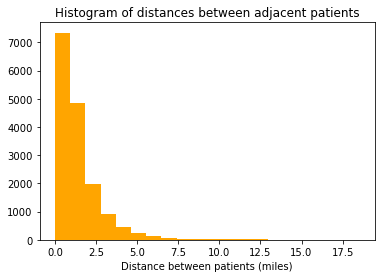

In [66]:
dist_df = locdf2.loc[(locdf2["distances"].notnull())].groupby("cluster_no").mean()

plt.title("Histogram of distances between adjacent patients")
plt.xlabel("Distance between patients (miles)")
plt.hist((dist_df["distances"] * detour_index) /(1.6 * 1000), bins=20, color="orange")

### Unoptimised: EMIS ordering (descoped from paper)

In [67]:
%%time
locdf3 = locdf2.sort_values(["record_index", "patient_index"])

unoptimised = []

record_index = ""
cluster_no = 1

for index, row in locdf3.iterrows():
    if row["record_index"] != record_index:
        record_index = row["record_index"]
        cluster_no = 1
    if row["patient_index"] == row["max_cluster_size"]:
        cluster_no += 1
    unoptimised.append(str(record_index) + "_" + str(cluster_no))
            
locdf3["cluster_no"] = unoptimised

Wall time: 23.3 s


In [77]:
# recalculate unoptimised distances
locdf3["distances"] = locdf3.geometry.distance(locdf3.geometry.shift(1))
locdf3["distances"] = np.where((locdf3.cluster_no == locdf3.cluster_no.shift(1)), locdf3["distances"], np.nan)

print("Distance travelled unoptimised EMIS = {:,} Miles".format(int(round((locdf3.distances.sum() * detour_index) / (1.6 * 1000), -3))))
print("Total Hours unoptimised EMIS = {:,} h"\
      .format(int(round((locdf3.distances.sum() * detour_index) / (1.6 * 1000 * avg_road_speed), 0))))

Distance travelled unoptimised EMIS = 519,000 Miles
Total Hours unoptimised EMIS = 17,295 h


### Random assignment inter + intra cluster


In [78]:
dist_distances_1 = []

In [311]:
%%time

for i in tqdm(range(1, 2, 1)):
    
    locdf4 = locdf2.sample(frac=1).sort_values("record_index")

    unoptimised = []

    record_index = ""
    cluster_no = 1
    patient_no = 1

    for index, row in locdf4.iterrows():
        if row["record_index"] != record_index:
            record_index = row["record_index"]
            cluster_no = 1
            patient_no = 1
        if patient_no > row["max_cluster_size"]:
            cluster_no += 1
            patient_no = 1
        if patient_no <= row["max_cluster_size"]:
            patient_no += 1
        unoptimised.append(str(record_index) + "_" + str(cluster_no))

    locdf4["cluster_no"] = unoptimised
    
    # recalculate unoptimised distances
    locdf4["distances"] = locdf4.geometry.distance(locdf4.geometry.shift(1))
    locdf4["distances"] = np.where((locdf4.cluster_no == locdf4.cluster_no.shift(1)), locdf4["distances"], np.nan)

    
    dist_distances_1.append((locdf4.distances.sum() * detour_index) / (1.6 * 1000))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:24<00:00, 24.13s/it]

Wall time: 24.1 s


In [312]:
len(dist_distances_1)

270

(array([ 4.,  2.,  2.,  6.,  5.,  3.,  5.,  3., 11.,  9., 15., 14., 28.,
        36., 32., 44., 22., 20.,  4.,  5.]),
 array([749.48024493, 750.87764865, 752.27505237, 753.67245608,
        755.0698598 , 756.46726351, 757.86466723, 759.26207095,
        760.65947466, 762.05687838, 763.45428209, 764.85168581,
        766.24908952, 767.64649324, 769.04389696, 770.44130067,
        771.83870439, 773.2361081 , 774.63351182, 776.03091554,
        777.42831925]),
 <BarContainer object of 20 artists>)

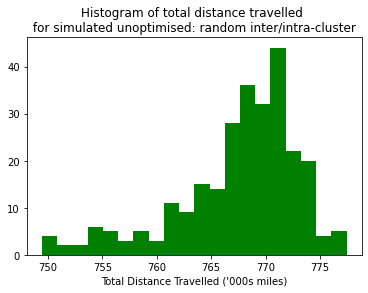

In [313]:
plt.title("Histogram of total distance travelled \n for simulated unoptimised: random inter/intra-cluster ")
plt.xlabel("Total Distance Travelled ('000s miles)")
plt.hist([(x / 1000) for x in dist_distances_1], bins=20, color="green")

In [315]:
# test data for nomality: lilliefors / shapiro-Wilks tests

# lilliefors
print("Lilliefors statistic, p-value = {}".format(sm.stats.lilliefors(dist_distances_1)))

# shapiro
W, p = shapiro(dist_distances_1)
print("Shapiro-Wilk test statistic, W:", W, "\n", "p-value:", p)

Lilliefors statistic, p-value = (0.12697379498611222, 0.0009999999999998899)
Shapiro-Wilk test statistic, W: 0.9155565500259399 
 p-value: 3.260465855636774e-11


In [320]:
# average distance travlled / stats
print("Distance travelled unoptimised inter + intra = {:,} Miles".format(int(round(np.mean(dist_distances_1)))))
print("Total Hours unoptimised inter + intra = {:,} h"\
      .format(int(round(np.mean(dist_distances_1) / avg_road_speed))))

Distance travelled unoptimised inter + intra = 767,549 Miles
Total Hours unoptimised inter + intra = 25,585 h


In [300]:
# get improvement of optimised route
stats.percentileofscore(dist_distances_1, 220000)

0.0

In [481]:
# CHECKPOINT: Save run1 as textfile
dist_distances_1_textfile = open("dist_distances_1.txt", "w")
for element in dist_distances_1:
    dist_distances_1_textfile.write(str(element) + "\n")
dist_distances_1_textfile.close()

In [93]:
# CHECKPOINT: Open Run 1 as textfile
with open("dist_distances_1.txt") as f:
    dist_distances_1 = f.readlines()
    
dist_distances_1 = [float(x.replace("\n", "")) for x in dist_distances_1]

### Random assignment intra cluster

In [80]:
dist_distances_2 = []

In [83]:
%%time

for i in range(1, 200, 1):
    
    locdf5 = locdf2.sample(frac=1).sort_values("cluster_no")

    # recalculate unoptimised distances
    locdf5["distances"] = locdf5.geometry.distance(locdf5.geometry.shift(1))
    locdf5["distances"] = np.where((locdf5.cluster_no == locdf5.cluster_no.shift(1)), locdf5["distances"], np.nan)

    
    dist_distances_2.append((locdf5.distances.sum() * detour_index) / (1.6 * 1000))

KeyboardInterrupt: 

In [340]:
len(dist_distances_2)

1000

In [536]:
stats.kstest(stats.t.rvs(3, size=100, random_state=rng), "norm")

KstestResult(statistic=0.11494356250735578, pvalue=0.13156246292069174)

(array([  3.,   4.,   6.,  23.,  28.,  54.,  86., 112., 109., 121., 136.,
        102.,  77.,  62.,  28.,  17.,  21.,   7.,   1.,   3.]),
 array([392.1949845 , 392.66218772, 393.12939094, 393.59659416,
        394.06379739, 394.53100061, 394.99820383, 395.46540705,
        395.93261028, 396.3998135 , 396.86701672, 397.33421995,
        397.80142317, 398.26862639, 398.73582961, 399.20303284,
        399.67023606, 400.13743928, 400.6046425 , 401.07184573,
        401.53904895]),
 <BarContainer object of 20 artists>)

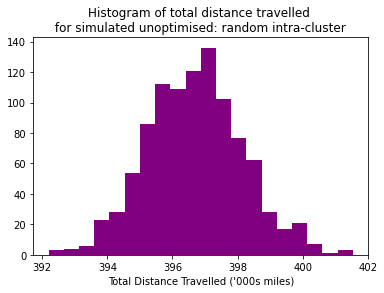

In [355]:
plt.title("Histogram of total distance travelled \n for simulated unoptimised: random intra-cluster ")
plt.xlabel("Total Distance Travelled ('000s miles)")
plt.hist([(x / 1000) for x in dist_distances_2], bins=20, color="purple")

In [346]:
# test data for nomality: lilliefors / shapiro-Wilks tests

# lilliefors
print("Lilliefors statistic, p-value = {}".format(sm.stats.lilliefors(dist_distances_2)))

# shapiro
W, p = shapiro(dist_distances_2)
print("Shapiro-Wilk test statistic, W:", W, "\n", "p-value:", p)

(396689.42322920443, 1468.2360476789602, 13222.980774306814)

In [ ]:
# average distance travlled / stats
print("Distance travelled unoptimised intra = {:,} Miles".format(int(round(np.mean(dist_distances_2))))
print("Total Hours unoptimised inter + intra = {:,} h"\
      .format(int(round(np.mean(dist_distances_2 / avg_road_speed)))))

In [516]:
# get improvement of optimised route
stats.percentileofscore(dist_distances_2, 220000)

120.35855784994969

In [461]:
# CHECKPOINT: Save Run 2 as textfile
dist_distances_2_textfile = open("dist_distances_2.txt", "w")
for element in dist_distances_2:
    dist_distances_2_textfile.write(str(element) + "\n")
dist_distances_2_textfile.close()

In [89]:
# CHECKPOINT: Open Run 2 as textfile
with open("dist_distances_2.txt") as f:
    dist_distances_2 = f.readlines()

## Appendix

## Appendix 1: Unfinished Analysis (not required currently)

### Mean Cluster Diameter

In [195]:
locdf2.groupby("submission").count().sort_values("cluster_length", ascending=False)[1000:1010]

,latlongs,cluster_no,geometry,cluster_length
submission,,,,
2198,4,4,4,4
3826,4,4,4,4
3066,4,4,4,4
2104,4,4,4,4
3086,4,4,4,4
2854,4,4,4,4
3809,4,4,4,4
4071,4,4,4,4
2371,4,4,4,4


### Hierarchical Clustering

(Iterative) K-Means clustering is being used currently to:
   * Find the centroid of G clusters
   * Populate clusters using ranking based on optimisation penalty, each cluster given patient size <=D, based on distances between patient lat/lon and centroid lat/lon (similar to https://elki-project.github.io/tutorial/same-size_k_means)
   
(we assume that cluster label, which is integer, has no cardinal value).

K-means uses Euclidean-based distance metrics, however since lat/lon coordinates are on a geodesic, there may be some error when comparing distances. One way to get around this is clustering using HDBSCAN (Hierarchical Density-Based Spatial Clustering), but you cannot set the number of clusters: it instead words to find spatially dense areas with nearest neighbour / separation between clusters being prime parameters.

A better tool than HDBSCAN is tree-based Hierarchical clustering, since it can support haversine metrics to accurately calculate lat/lon distance, you can set number of clusters and it is non-parametric. Centre of cluster = mean value of items. There is an iterative fashion to achieve this using the outline described here (http://jmonlong.github.io/Hippocamplus/2018/06/09/cluster-same-size/#iterative-bottom-leaves-hierarchical-clustering).

To then find which centroids map to which patients, there is an optimisation algorithm p-median (more details here: http://courses.ieor.berkeley.edu/ieor151/lecture_notes/ieor151_lec13.pdf) to reduce the distance between centroid and patient. I will look at (i) constraint that means size of cluster = max_cluster_size (and see what happens with leftover patients), or add another objective to maximise patient numbers per cluster up to max cluster size.

N.B. prerequisite is that lat/lon must be converted into radians beforehand. We do this using a simply using inbuilt numpy function radians to convert entire coordinate array.

Other ideas:
Springer: balanced K means: https://link.springer.com/chapter/10.1007/978-3-662-44415-3_4
Kmedoids: https://github.com/OmarAflak/kmedoids/blob/master/constrained_kmedoids.py

In [14]:
df.head(1)

,n_patients,n_clusters,latlong,clusters,region,postcodes,created,mode,max_cluster_size,postcodes_size
2,11,1,"[[-0.00422240000000329, -0.010207700000000014], [0.0017050999999810301, 0.0027945999999999804], [-0.0019168000000036045, -0.004896500000000026], [0.0014654999999947904, 0.007844799999999985], [0.0017771999999922627, -0.0046426000000000245], [0.005728599999990536, 0.0037821999999999856], [-0.004459200000006547, -0.0035046999999999995], [0.0031894999999906304, 0.008110899999999976], [0.0031894999999906304, 0.008110899999999976], [-0.003712000000007265, 0.0028246999999999856], [-0.002745000000018649, -0.01021660000000002]]","[[2, 6, 9, 0, 10, 4, 1, 5, 8, 7, 3]]",UK,{},2021-01-23,driving,11,0


In [15]:
def distanceIterHierarchicalClustering(latlon, n_clusters, max_cluster_size, linkage="average"):
    # convert lat/lon to radians
    latlon_rad = np.radians(latlon)
    print("N patients = {a}, N clusters = {b}, Max size = {c}".format(a=len(latlon), b=n_clusters, c=max_cluster_size))
    
    # compute pairwise haversine distances between each lat/lon point
    haversine_pairwise = haversine_distances(latlon_rad)
    
    # define clustering algorithm and predict for points
    clusterer = AgglomerativeClustering(affinity='precomputed', n_clusters=n_clusters,
                                        linkage=linkage, distance_threshold=None,
                                        compute_distances=True, compute_full_tree=False)
    
    # Iterative clustering method
    model = clusterer.fit(haversine_pairwise)
    print(model.get_params())

    
    plot_dendrogram(model, truncate_mode='level', p=3)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    model = clusterer.fit_predict(haversine_pairwise)
    
    # convert to indices of lat/lon
    patients = []
    for k in range(n_clusters):
        patients.append([i for i, j in enumerate(model) if j == k])
        
    print(patients)
    return patients
    

N patients = 11, N clusters = 1, Max size = 11
{'affinity': 'precomputed', 'compute_distances': True, 'compute_full_tree': False, 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'n_clusters': 1}


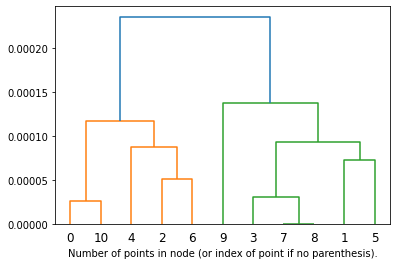

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
N patients = 20, N clusters = 2, Max size = 10
{'affinity': 'precomputed', 'compute_distances': True, 'compute_full_tree': False, 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'n_clusters': 2}


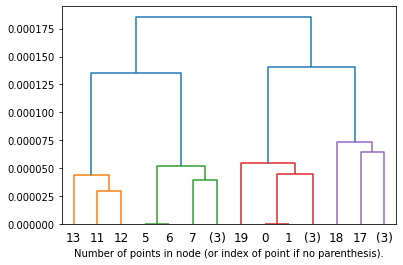

[[0, 1, 2, 3, 4, 14, 15, 16, 17, 18, 19], [5, 6, 7, 8, 9, 10, 11, 12, 13]]
N patients = 32, N clusters = 4, Max size = 10
{'affinity': 'precomputed', 'compute_distances': True, 'compute_full_tree': False, 'connectivity': None, 'distance_threshold': None, 'linkage': 'average', 'memory': None, 'n_clusters': 4}


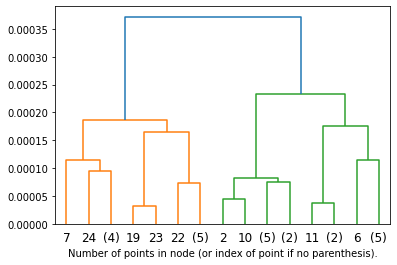

[[6, 11, 12, 13, 14, 15, 16, 17, 18], [19, 22, 23, 25, 26, 27, 30, 31], [0, 1, 2, 3, 4, 5, 8, 9, 10], [7, 20, 21, 24, 28, 29]]


In [16]:
# Output hierarchichal clustering and resulting dendrograms for 3 examples
for i in range(len(df[:3])):
    distanceIterHierarchicalClustering(df["latlong"].values[i], df["n_clusters"].values[i], \
                                   df["max_cluster_size"].values[i], linkage="average")

#### Optimisation algorithm for finding best distribution of patients given number of centroids 

Adapted from https://github.com/ralaruri/p_median_python

In [17]:
# change so that rows = patients, columns = centroids, values = distances

In [18]:
from pulp import *
import time

locations_1 = np.radians(df.latlong.values[0])
locations_1 = np.append(locations_1, [[5.56e-04, 1.413e-04]], axis=0)

pairwise_distance_df = pd.DataFrame(haversine_distances(locations_1))
centroids = pairwise_distance_df.keys()
patient = pairwise_distance_df.index


# start counting time
t1=time.time()

p = 2 #  number of locations to optimize to


# declare patient variables
X = LpVariable.dicts('X',(centroids), 0, 1, LpInteger)

# declare decision variables
Y = LpVariable.dicts('Y', (patient, centroids), 0, 1, LpInteger) 

# create the LP object, set up as a MINIMIZATION problem
prob = LpProblem('P Median', LpMinimize)

# prob += sum(sum(D[i][j] * Y[i][j] for j in location) for i in patient)
# pandas iloc looks up values by row(i) and column(j)
prob += sum(sum(pairwise_distance_df.iloc[i,j] * Y[i][j] for j in centroids) for i in patient)

# set up constraints
# This is same as prob += sum([X[j] for j in location]) == p
prob += lpSum([X[j] for j in centroids]) == p

# constraint: make sure that each patient is connected to one centroid
for i in patient: prob += sum(Y[i][j] for j in centroids) == 1

for i in patient:
    for j in centroids: 
        prob +=  Y[i][j] <= X[j]


prob.solve()

#  format output
print(' ')
print("Status:",LpStatus[prob.status])
print(' ')
print("Objective: ",value(prob.objective))
print(' ')

for v in prob.variables():
    subV = v.name.split('_')
    
    if subV[0] == "X" and v.varValue == 1: print('p-Median Node: ', subV[1])

result = []   
'''print(' ')
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: print(subV[1], ' is connected to', subV[2])'''

print(' ')
for v in prob.variables():
    subV = v.name.split('_')
    if subV[0] == "Y" and v.varValue == 1: 
        result.append((subV[1], ' is connected to', subV[2]))
print(result)

dfo = pd.DataFrame(np.array(result))

 
Status: Optimal
 
Objective:  0.001163296353385322
 
p-Median Node:  2
p-Median Node:  7
 
[('0', ' is connected to', '2'), ('10', ' is connected to', '2'), ('11', ' is connected to', '7'), ('1', ' is connected to', '7'), ('2', ' is connected to', '2'), ('3', ' is connected to', '7'), ('4', ' is connected to', '2'), ('5', ' is connected to', '7'), ('6', ' is connected to', '2'), ('7', ' is connected to', '7'), ('8', ' is connected to', '7'), ('9', ' is connected to', '2')]


## Appendix 2: Ideas / Notes

###  Potential Areas for Analysis

**1) Evaluate error using UK centre coordinate vs coordinate from high level postcode** <br>
Affects ~10% of points. Would need to convert level postcode into lat/lon. Not sure if interesting for paper as we do not practically use this anonymised dataset when route planning. <br>


### General notes and questions:

Github Codebase:
* requirements.txt: requires "tables" module and also need python=3.8

Paper:
* Cite TSP in line 8
* Need to confirm vial size, in paper says 9 but on website it says 11

Data:
* Website has Time per Patient column, why is this omitted from dataset?

Other Notes (For personal reference):

* D = number of patients per cluster, 3 <= D <= 25. One vial of AstraZeneca has D=9 vials
* Number of groups G = ceil(N/D), N = number of patients
* Iterative k-means produces centroids, then ranks based on optimisation penalty (distance_furthest_centroid - distance_nearest_centroid), so those equidistant to centroids rank less and those close to only one rank more
* I'm assuming that we treat each cluster as one set of delivery and is constrained by D, G = group size = number of delivery sessions
* EMIS Database would likely store patients randomly
* In doc multiplying by 1.2 to take into account fact roads are not straight